In [1]:
pip install torcheval 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split

import torcheval.metrics.functional as metrics

from tqdm import tqdm

import torchaudio.transforms as T




torch.manual_seed(1000) # set the random seed

# Loading Data

In [3]:

class SleepData(Dataset):
    def __init__(self, hr_file, ecg_file, window_size=30, apply_spectrogram=False, num_outputs = 4):
        self.df1 = pd.read_csv(hr_file)
        self.df2 = pd.read_csv(ecg_file)
        self.window_size = window_size
        self.apply_spectrogram = apply_spectrogram
        self.num_outputs = num_outputs


        self.freq1 = 1
        self.freq2 = 256
        
        # Spectrogram transformation
        self.transform = T.Spectrogram(n_fft=256, normalized = True)
        

    def __len__(self):
        len1 = len(self.df1) // (self.freq1 * self.window_size)
        len2 = len(self.df2) // (self.freq2 * self.window_size)
        return round(min(len1, len2))

    def __getitem__(self, idx):
        start_window1 = self.window_size * idx * self.freq1
        start_window2 = self.window_size * idx * self.freq2
        
        # Extract heart rate data points and label for the current window
        hr = self.df1['heart_rate'].iloc[start_window1:start_window1 + self.window_size * self.freq1].values
        labels = self.df1['psg_status'].iloc[start_window1]
        
        '''
        MESA
        0: SleepStage.wake,
        1: SleepStage.n1,
        2: SleepStage.n2,
        3: SleepStage.n3,
        4: SleepStage.n4,
        5: SleepStage.rem
        
        Apple Watch:
        Awake
        Core: N1, N2
        Deep: N3 (+ N4)
        REM
        '''
        
        
        if self.num_outputs == 4:
            if labels in [1, 2]:
                labels = 1
            elif labels in [3, 4]:
                labels = 2
            elif labels == 5:
                labels = 3
        
        elif self.num_outputs == 2:
            if labels in [1, 2, 3, 4, 5]:
                labels = 1

        ecg = self.df2['ECG'].iloc[start_window2:start_window2 + self.window_size * self.freq2].values

        # Convert to PyTorch tensors
        hr = torch.tensor(hr, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        labels = torch.tensor(labels, dtype=torch.long)
        ecg = torch.tensor(ecg, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        
        
        if self.apply_spectrogram:
            # Apply spectrogram transformation to ECG signal
            spectrogram = self.transform(ecg)
            # Apply log transform to spectrogram
            spectrogram = T.AmplitudeToDB()(spectrogram)

            #normalize between 0 and 1 
            # Calculate the minimum and maximum values of the input data
            min_value = torch.min(spectrogram)
            max_value = torch.max(spectrogram)

            # Normalize the input data to be between 0 and 1
            spectrogram = (spectrogram - min_value) / (max_value - min_value)
                        
            return hr, spectrogram, labels
        else:
            return hr, ecg, labels


In [4]:

hr_data = r'/kaggle/input/hr-data/subject_0002.csv'
ecg_data = r'/kaggle/input/ecgdata/subject_0002_ecg.csv'
dataset1D = SleepData(hr_data,ecg_data,apply_spectrogram=False)


# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset1D))  # 70% of the data for training
val_size = int(0.15 * len(dataset1D))   # 15% of the data for validation
test_size = len(dataset1D) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset1D, val_dataset1D, test_datase1D = random_split(dataset1D, [train_size, val_size, test_size])



# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loader1D = DataLoader(train_dataset1D, batch_size=batch_size, shuffle=True)
valid_loader1D = DataLoader(val_dataset1D, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecg1D, labels1D) in enumerate(train_loader1D):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecg1D.shape)
    print("Labels Shape:", labels1D.shape)
    if batch_idx == 0:
        break




Batch Index: 0
Input Shape: torch.Size([32, 1, 7680])
Labels Shape: torch.Size([32])


In [57]:

dataset2D = SleepData(hr_data,ecg_data,apply_spectrogram=True)


# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset2D))  # 70% of the data for training
val_size = int(0.15 * len(dataset2D))   # 15% of the data for validation
test_size = len(dataset2D) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset2D, val_dataset2D, test_dataset2D = random_split(dataset2D, [train_size, val_size, test_size])



# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loader2D = DataLoader(train_dataset2D, batch_size=batch_size, shuffle=True)
valid_loader2D = DataLoader(val_dataset2D, batch_size=batch_size, shuffle=False)
test_loader2D = DataLoader(test_dataset2D, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecg2D, labels2D) in enumerate(train_loader2D):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecg2D.shape)
    print("Labels Shape:", labels2D.shape)
    if batch_idx == 0:
        break




Batch Index: 0
Input Shape: torch.Size([32, 1, 129, 61])
Labels Shape: torch.Size([32])


In [6]:
#check how many are in each label/for each daatset 

# Feature Extraction

## 1. 1D CNN + LSTM

### Model 0. CNN + LSTM V1 

In [7]:



class CNNblock(nn.Module):
    def __init__(self,in_channels=1, out_channels=60,kernel_size=64):
        super(CNNblock, self,).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride = 2)
        self.dropout= nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        return x
    

class LSTM1(nn.Module):
    def __init__(self, k1 = 64, k2 = 32, k3 = 16):
        super(LSTM1, self).__init__()
        
        # Batch normalization
        self.batchnorm = nn.BatchNorm1d(1)
        

        # Convolutional layers
        self.conv1 = CNNblock(in_channels = 1, out_channels = 60, kernel_size = k1)
        self.conv2 = CNNblock(in_channels = 60, out_channels = 30, kernel_size = k2)
        self.conv3 = CNNblock(in_channels = 30, out_channels = 10, kernel_size = k3)
        
        
        
        # GRU layers
        #self.gru1 = nn.GRU(input_size=k3, hidden_size=20, batch_first=True)
        #self.gru2 = nn.GRU(input_size=k3, hidden_size=10, batch_first=True)

        #replace with LSTM? 
        self.LSTM = nn.LSTM(input_size = 10, hidden_size = 10, bidirectional = True, num_layers = 2)
        
        
    def forward(self, x):
        # Batch normalization
        x = self.batchnorm(x)
        
       # print(x.shape)
        # Convolutional layers
        x = self.conv1(x)
        #print(x.shape)

        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)

        # Reshape for GRU input
        x = x.permute(0, 2, 1)  # Swap dimensions for RNN input
        #print(x.shape)

        # GRU layers
        #x, _ = self.gru1(x)
        #x = self.dropout4(x)
        
        #x, _ = self.gru2(x)
        #x = self.dropout(x)


        out, _ = self.LSTM(x)

        #print(out.shape)

        out_pooled = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        #print(out_pooled.shape)
        return out_pooled



In [8]:
model = LSTM1()
x = model(ecg1D)
x.shape

torch.Size([32, 40])

### 1b. CNN + LSTM V2

In [9]:
# based on: https://github.com/akaraspt/tinysleepnet

#returns features and then u can put into MLP separately 
class LSTM2(nn.Module):
    def __init__(self):
        super(LSTM2,self).__init__()
        self.pool1 = nn.MaxPool1d(8, 8) #kernel_size, stride
        self.pool2 = nn.MaxPool1d(4, 4) #kernel_size, stride

        self.conv1 = nn.Conv1d(1, 128, 8) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv1d(128, 128, 8) #in_channels, out_chanels, kernel_size

        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(128,128)
    

        

    def forward(self, ecg):
        
        ecg = self.pool1(ecg)
        
        ecg = self.dropout(ecg)
        ecg = F.relu(self.conv1(ecg))
        ecg = F.relu(self.conv2(ecg))
        ecg = self.pool2(F.relu(self.conv2(ecg)))
        ecg = self.dropout(ecg)

        #print(ecg.shape)

        # Transpose dimensions for LSTM input
        ecg = ecg.permute(0, 2, 1)  # Swap dimensions for RNN input
        #print(ecg.shape)
        ecg, _ = self.lstm(ecg)
        #print(ecg.shape)
        ecg = self.dropout(ecg)

        out_pooled = torch.cat([torch.max(ecg, dim=1)[0], torch.mean(ecg, dim=1)], dim=1)
        #print(ecg.shape)

        return out_pooled



In [10]:
model = LSTM2()
x = model(ecg1D)
x.shape

torch.Size([32, 256])

## 2. 2D Spectrogram

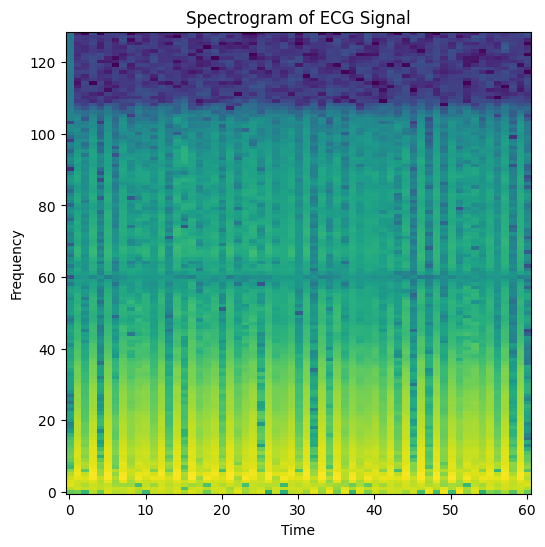

In [11]:

# Plot the spectrogram
plt.figure(figsize=(6, 6))
plt.imshow(ecg2D[4][0], origin='lower', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of ECG Signal')
plt.show()



### 2a. Spectrogram + CNN 

In [41]:
#from here  https://arxiv.org/pdf/2005.06902.pdf

class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        
        # Spectrogram transformation
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3))
        
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.dropout = nn.Dropout(p=0.2)
        

    def forward(self, x):

        

        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)

        x = F.relu(self.conv4(x))
        x = self.maxpool(x)

        # Flatten
        x = x.view(x.size(0), -1)
        
        #dropout 
        
        return x




In [55]:
model = SpectrogramCNN()
x = F.interpolate(ecg2D, size=(256,256), mode='bicubic')
x = model(x)
x.shape

torch.Size([32, 100352])

### 2b. Spectrogram + AlexNet Features

In [14]:

import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 168MB/s] 


In [15]:
x = F.interpolate(ecg2D, size=(227,227), mode='bicubic')
rgb_x = x.repeat(1,3, 1, 1)
print(rgb_x.shape)
features = alexnet.features(rgb_x)
print(features.shape)



torch.Size([32, 3, 227, 227])
torch.Size([32, 256, 6, 6])


In [16]:
#pre-extract AlexNet Features
#i'm doing it here bc i don't wanna load alexnet in the training loop but idk if this computationally better
train_datasetAN, val_datasetAN, test_datasetAN = [], [], []

for hr, ecg, labels in tqdm(train_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    train_datasetAN.append([hr, features, labels])

for hr, ecg, labels in tqdm(val_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    val_datasetAN.append([hr,features, labels])

for hr, ecg, labels in tqdm(test_dataset2D):
    x = ecg.unsqueeze(0)
    x = F.interpolate(x, size=(227,227), mode='bicubic')
    x = x.repeat(1,3, 1, 1)
    features = alexnet.features(x)
    features = features.squeeze()
    test_datasetAN.append([hr, features, labels])





100%|██████████| 156/156 [00:02<00:00, 74.60it/s]


In [17]:
x.shape

torch.Size([1, 3, 227, 227])

In [18]:
# Define batch size
batch_size = 32

# Create DataLoaders for training and validation
train_loaderAN = DataLoader(train_datasetAN, batch_size=batch_size, shuffle=True)
valid_loaderAN = DataLoader(val_datasetAN, batch_size=batch_size, shuffle=False)



for batch_idx, (_, ecgAN, labelsAN) in enumerate(train_loaderAN):
    print("Batch Index:", batch_idx)
    print("Input Shape:", ecgAN.shape)
    print("Labels Shape:", labelsAN.shape)
    if batch_idx == 0:
        break


Batch Index: 0
Input Shape: torch.Size([32, 256, 6, 6])
Labels Shape: torch.Size([32])


In [19]:
#can also just try trainign alexnet myself 

# Final Classifier + Testing

## 1D

In [20]:
class Classifier1D(nn.Module):
    def __init__(self, out_size = 4, hidden_size1 = 64, hidden_size2 = 32, model = 0):
        super(Classifier1D, self).__init__()

        if model == 0:
            self.mymodel = LSTM1()
            self.in_size = 40

        elif model == 1:
            self.mymodel = LSTM2()
            self.in_size = 256


        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)
        
    def forward(self,x):
        
        out = self.mymodel(x)
        

        #print(out.shape)
        #flatten
        out = out.view(-1, self.in_size)
        

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)

        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

In [21]:
use_cuda = False
model= Classifier1D(model = 0)

x= model(ecg1D)
x.shape

torch.Size([32, 4])

## Multi Feature
Multiple time-series inputs of min length 64 & runs each of them through a LSTM

In [22]:
class Classifier1D_multi(nn.Module):
    def __init__(self, out_size = 4, hidden_size1 = 64, hidden_size2 = 320,num_inputs = 2):
        super(Classifier1D_multi, self).__init__()

        self.mymodel = LSTM1()
        self.in_size = 40
        self.num_inputs = num_inputs



        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size*self.num_inputs, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)
        
    def forward(self, *inputs):
        outputs = [self.mymodel(input) for input in inputs]
        out = torch.cat(outputs, dim=1)

        #print(out.shape)
        #flatten
        out = out.view(-1, self.in_size*self.num_inputs)
        

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)

        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

Concatenates features to those extracted from LSTM

In [23]:
class Classifier1D_feats(nn.Module):
    def __init__(self, out_size = 4, feat_size = 30, hidden_size1 = 64, hidden_size2 = 320):
        super(Classifier1D_feats, self).__init__()

        self.mymodel = LSTM1()
        self.in_size = 40
        self.feat_size = feat_size


        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size+self.feat_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)
        
    def forward(self,x,feats):
        
        out = self.mymodel(x)

        #print(out.shape)
        #flatten
        out = out.view(-1, self.in_size)
        feats = feats.view(-1, self.feat_size)


        out = torch.cat((out, feats),dim=1)


        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)

        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

In [24]:
for batch_idx, (hr1D, ecg1D, labels1D) in enumerate(train_loader1D):
    print("Batch Index:", batch_idx)
    print("HR Shape:", hr1D.shape)
    print("ECG Shape:", ecg1D.shape)
    print("Labels Shape:", labels1D.shape)
    if batch_idx == 0:
        break

Batch Index: 0
HR Shape: torch.Size([32, 1, 30])
ECG Shape: torch.Size([32, 1, 7680])
Labels Shape: torch.Size([32])


In [25]:
model = Classifier1D_feats()
x = model(ecg1D,hr1D)
x.shape


torch.Size([32, 4])

## 2D 

conv network

In [105]:
class Classifier2D(nn.Module):
    def __init__(self, model = 0, out_size = 4, hidden_size1 = 64, hidden_size2 = 32):
        super(Classifier2D, self).__init__()
        self.model = model
        if model == 0:
            self.mymodel = SpectrogramCNN()
            self.in_size = 100352 
        elif model == 1:
            self.mymodel = torchvision.models.alexnet(weights='DEFAULT')
            self.in_size = 256*6*6

        if use_cuda and torch.cuda.is_available():
            self.mymodel.cuda()

        
        
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size


        self.fc1 = nn.Linear(self.in_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, self.out_size)

        
    def forward(self,x):
        
        if self.model ==0:
            x = F.interpolate(x, size=(256,256), mode='bicubic')
            out = self.mymodel(x)

        if self.model == 1:
            x = F.interpolate(x, size=(227,227), mode='bicubic')
            x = x.repeat(1,3, 1, 1)
            out = self.mymodel.features(x)

     
        #flatten
        out = out.view(-1, self.in_size)
        #print(out.shape)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        #print(out.shape)
        out = self.fc3(out)
        #print(out.shape)
        out = out.squeeze(1) # Flatten to [batch_size]
        #print(out.shape)
        return out
        

In [70]:
model = Classifier2D(model = 0)
use_cuda = False
x = model(ecg2D)
x.shape


torch.Size([32, 1, 256, 256])
torch.Size([32, 100352])


torch.Size([32, 4])

pretrained AlexNet

In [28]:

class ClassifierAN(nn.Module):
    def __init__(self, l1 = 64, l2 = 32, out_size = 4):
        super(ClassifierAN, self).__init__()
        
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size
        
        self.fc1 = nn.Linear(256 * 6 * 6, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, out_size)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [29]:
model = ClassifierAN()
x = model(ecgAN)
x.shape


torch.Size([32, 4])

pretrained + HR

In [30]:

class ClassifierAN_feats(nn.Module):
    def __init__(self, l1 = 64, l2 = 32, out_size = 4, num_inputs = 1,feat_size = 30):
        super(ClassifierAN_feats, self).__init__()
        
        if out_size == 2:
            self.out_size = 1
        else:
            self.out_size = out_size
        self.num_inputs = num_inputs
        self.feat_size = feat_size
        
        self.fc1 = nn.Linear(256 * 6 * 6 + self.feat_size, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, out_size)

    def forward(self, ecg, hr):

        x1 = ecg.view(-1, 256 * 6 * 6) 
        x2 = hr.view(-1,self.feat_size)
        x = torch.cat((x1,x2), dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [31]:
model = ClassifierAN_feats()
x = model(ecgAN,hr1D)
x.shape


torch.Size([32, 4])

# Training

In [32]:

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=0.001,num_classes = 4,num_inputs = 1):


    #calculate class weights (bc unblanced data)
    labels = []
    
    for batch in train_loader:
        _, _, label_batch = batch
        labels.append(label_batch)
    labels = torch.cat(labels, dim=0)

    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts.float())
    class_weights /= class_weights.sum()


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        class_weights = class_weights.cuda()
    #############################################

    
    if num_classes == 2: #binary classification
        criterion = nn.BCEWithLogitsLoss(weight = class_weights)
    else:
        criterion = nn.CrossEntropyLoss(weight = class_weights)


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, valid_losses = [], [], [], []
    epochs = []

    best_valid_acc = 0.0  # Initialize best validation accuracy
    best_model_state = None  # Initialize best model parameters

    for epoch in range(num_epochs):
        for hr,ecg,labels in train_loader:
            ecg.detach_()
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()
                hr = hr.cuda()


            optimizer.zero_grad()
            if num_inputs == 1:
                pred = model(ecg)
            elif num_inputs == 2:
                pred = model(ecg,hr)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
            
        
        losses.append(float(loss))

        
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            #for x in tqdm(iter(valid_loader)):
             # Evaluate validation loss on the first batch only
            val_data_iter = iter(valid_loader)
            hr, ecg, labels = next(val_data_iter)

            
            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()
                hr = hr.cuda()
            
            if num_inputs == 1:
                pred = model(ecg)
            elif num_inputs == 2:
                pred = model(ecg,hr)

            loss = criterion(pred, labels)
            valid_losses.append(float(loss))

        if epoch % 10 == 9:
            epochs.append(epoch)
            train_acc.append(get_accuracy(model, train_loader, num_classes,num_inputs))
            # Calculate validation accuracy and loss
            valid_acc.append(get_accuracy(model, valid_loader,num_classes,num_inputs))

            print("Epoch %d; Train Loss %f; Train Acc %f; Val loss %f; Val Acc %f" % (
              epoch+1, losses[-1], train_acc[-1],valid_losses[-1], valid_acc[-1]))

            if valid_acc[-1] > best_valid_acc:
              best_valid_acc = valid_acc[-1]
              best_model_state = model.state_dict()

        model.train()
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Best Valid Acc:",best_valid_acc)

    return best_model_state










In [33]:
def get_accuracy(model, data_loader,num_classes = 4, num_inputs = 1):
    model.eval()

    correct, total = 0, 0
    with torch.no_grad():
        for hr,ecg,labels in data_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                ecg = ecg.cuda()
                labels = labels.cuda()
                hr = hr.cuda()
            #############################################
            if num_inputs == 1:
                output = model(ecg)
            elif num_inputs == 2:
                output = model(ecg,hr)

            if num_classes ==2:
                pred = (torch.sigmoid(output) >= 0.5).float()
            else: 
                pred = output.max(1, keepdim=True)[1]
        
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
    return correct / total






In [34]:
def get_accuracy2(model, data_loader, num_classes = 4):
    model.eval()

    correct, total = 0, 0
    pred_out,labels_out= [], []
    with torch.no_grad():
      for _,ecg,labels in data_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              ecg = ecg.cuda()
              labels = labels.cuda()
            #############################################
            output = model(ecg)
            if num_classes ==1:
                pred = (torch.sigmoid(output) >= 0.5).float()
            else: 
                pred = output.max(1, keepdim=True)[1]
    
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
            labels_out.append(labels)
            pred_out.append(pred)
    return correct / total, labels_out, pred_out



training LSTM v1 

Epoch 10; Train Loss 1.369925; Train Acc 0.174515; Val loss 1.385086; Val Acc 0.194805
Epoch 20; Train Loss 1.394667; Train Acc 0.174515; Val loss 1.384111; Val Acc 0.194805
Epoch 30; Train Loss 1.386423; Train Acc 0.375346; Val loss 1.377888; Val Acc 0.409091
Epoch 40; Train Loss 1.270868; Train Acc 0.576177; Val loss 1.322757; Val Acc 0.584416
Epoch 50; Train Loss 1.202469; Train Acc 0.598338; Val loss 1.174736; Val Acc 0.597403
Epoch 60; Train Loss 1.110468; Train Acc 0.598338; Val loss 1.118737; Val Acc 0.584416
Epoch 70; Train Loss 1.129761; Train Acc 0.624654; Val loss 1.079631; Val Acc 0.571429
Epoch 80; Train Loss 1.013326; Train Acc 0.627424; Val loss 1.056138; Val Acc 0.538961
Epoch 90; Train Loss 1.051730; Train Acc 0.632964; Val loss 1.032398; Val Acc 0.564935
Epoch 100; Train Loss 0.979922; Train Acc 0.628809; Val loss 1.020612; Val Acc 0.577922
Epoch 110; Train Loss 0.973213; Train Acc 0.631579; Val loss 1.018884; Val Acc 0.551948
Epoch 120; Train Loss 0.920046; Train Acc

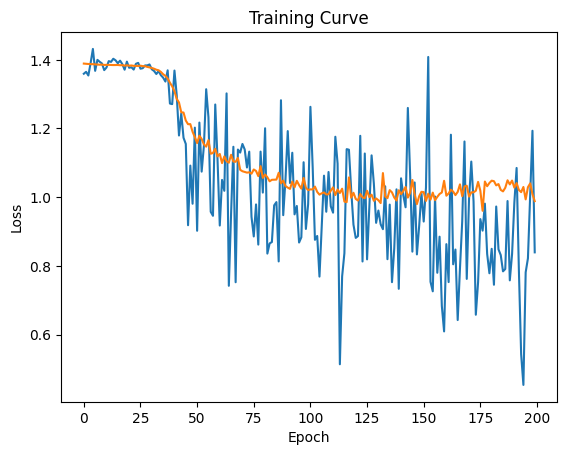

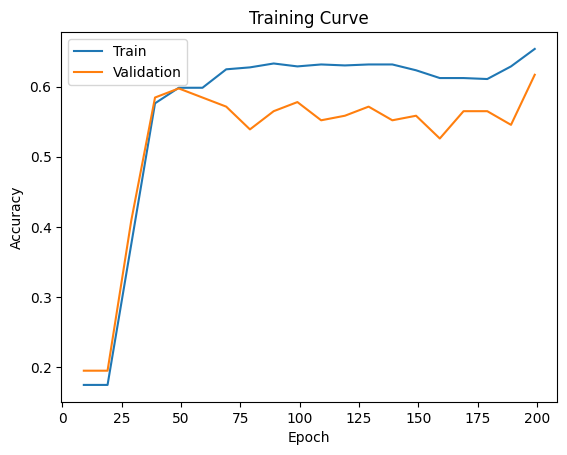

Best Valid Acc: 0.6168831168831169


In [35]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


Epoch 10; Train Loss 1.401548; Train Acc 0.397507; Val loss 1.385568; Val Acc 0.422078
Epoch 20; Train Loss 1.371334; Train Acc 0.448753; Val loss 1.376919; Val Acc 0.480519
Epoch 30; Train Loss 1.355247; Train Acc 0.513850; Val loss 1.319744; Val Acc 0.525974
Epoch 40; Train Loss 1.199931; Train Acc 0.601108; Val loss 1.135240; Val Acc 0.564935
Epoch 50; Train Loss 1.105277; Train Acc 0.578947; Val loss 1.145347; Val Acc 0.558442
Epoch 60; Train Loss 1.178518; Train Acc 0.594183; Val loss 1.128247; Val Acc 0.564935
Epoch 70; Train Loss 1.097393; Train Acc 0.576177; Val loss 1.156261; Val Acc 0.564935
Epoch 80; Train Loss 0.962655; Train Acc 0.612188; Val loss 1.072549; Val Acc 0.558442
Epoch 90; Train Loss 0.937045; Train Acc 0.596953; Val loss 1.084989; Val Acc 0.551948
Epoch 100; Train Loss 1.031156; Train Acc 0.603878; Val loss 1.059259; Val Acc 0.571429
Epoch 110; Train Loss 1.118950; Train Acc 0.609418; Val loss 1.079919; Val Acc 0.551948
Epoch 120; Train Loss 0.864350; Train Acc

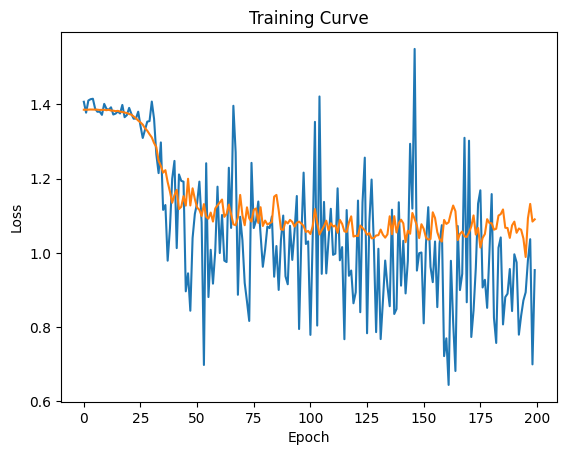

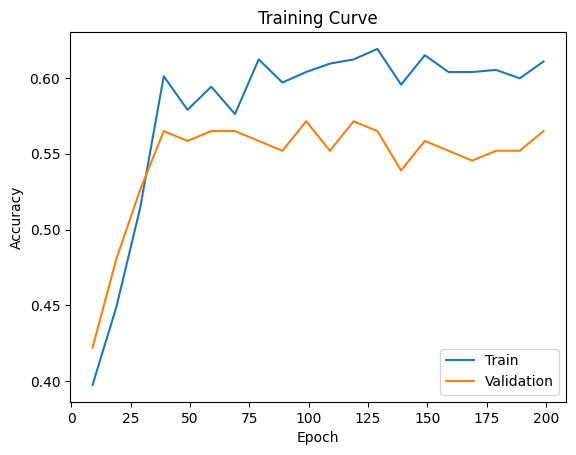

Best Valid Acc: 0.5714285714285714


In [36]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0,hidden_size1 = 128, hidden_size2 = 64)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


Epoch 10; Train Loss 1.391180; Train Acc 0.394737; Val loss 1.385941; Val Acc 0.415584
Epoch 20; Train Loss 1.381407; Train Acc 0.394737; Val loss 1.383345; Val Acc 0.415584
Epoch 30; Train Loss 1.358714; Train Acc 0.475069; Val loss 1.348760; Val Acc 0.500000
Epoch 40; Train Loss 1.001400; Train Acc 0.518006; Val loss 1.233158; Val Acc 0.493506
Epoch 50; Train Loss 1.204650; Train Acc 0.616343; Val loss 1.103320; Val Acc 0.551948
Epoch 60; Train Loss 1.032010; Train Acc 0.627424; Val loss 1.077668; Val Acc 0.564935
Epoch 70; Train Loss 0.740859; Train Acc 0.620499; Val loss 1.064563; Val Acc 0.545455
Epoch 80; Train Loss 0.865472; Train Acc 0.620499; Val loss 1.062771; Val Acc 0.538961
Epoch 90; Train Loss 1.187201; Train Acc 0.591413; Val loss 1.068773; Val Acc 0.564935
Epoch 100; Train Loss 1.043708; Train Acc 0.595568; Val loss 1.106919; Val Acc 0.571429
Epoch 110; Train Loss 0.789270; Train Acc 0.628809; Val loss 0.985780; Val Acc 0.564935
Epoch 120; Train Loss 0.942224; Train Acc

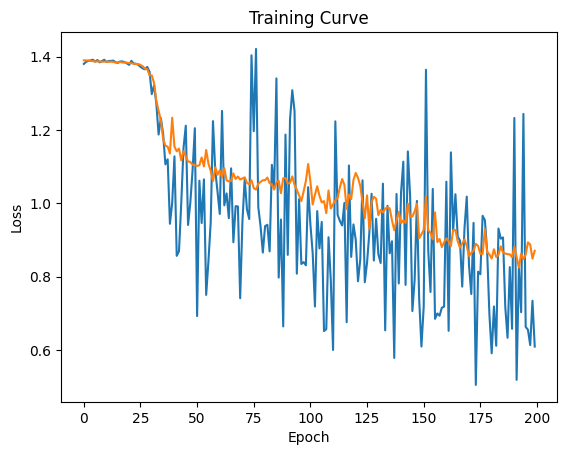

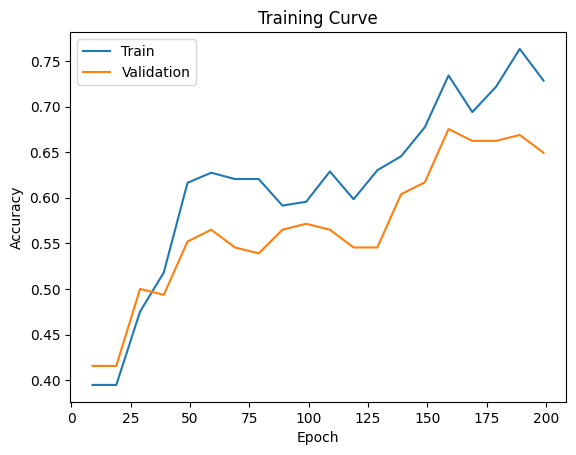

Best Valid Acc: 0.6753246753246753


In [37]:
#training LSTM v1 
use_cuda = True
model= Classifier1D(model = 0,hidden_size1 = 256, hidden_size2 = 128)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.0001);


LSTM + HR 

Epoch 10; Train Loss 0.958903; Train Acc 0.515235; Val loss 1.142487; Val Acc 0.512987
Epoch 20; Train Loss 1.254437; Train Acc 0.515235; Val loss 1.097712; Val Acc 0.525974
Epoch 30; Train Loss 1.157061; Train Acc 0.542936; Val loss 1.067820; Val Acc 0.571429
Epoch 40; Train Loss 1.191672; Train Acc 0.530471; Val loss 1.154217; Val Acc 0.519481
Epoch 50; Train Loss 1.210076; Train Acc 0.538781; Val loss 1.105153; Val Acc 0.558442
Epoch 60; Train Loss 1.100293; Train Acc 0.513850; Val loss 1.078597; Val Acc 0.500000
Epoch 70; Train Loss 0.810761; Train Acc 0.555402; Val loss 1.318298; Val Acc 0.500000
Epoch 80; Train Loss 1.026242; Train Acc 0.347645; Val loss 2.290300; Val Acc 0.305195
Epoch 90; Train Loss 1.019113; Train Acc 0.562327; Val loss 1.802914; Val Acc 0.545455
Epoch 100; Train Loss 0.657042; Train Acc 0.412742; Val loss 1.894969; Val Acc 0.376623
Epoch 110; Train Loss 0.804701; Train Acc 0.537396; Val loss 1.283420; Val Acc 0.441558
Epoch 120; Train Loss 0.673061; Train Acc

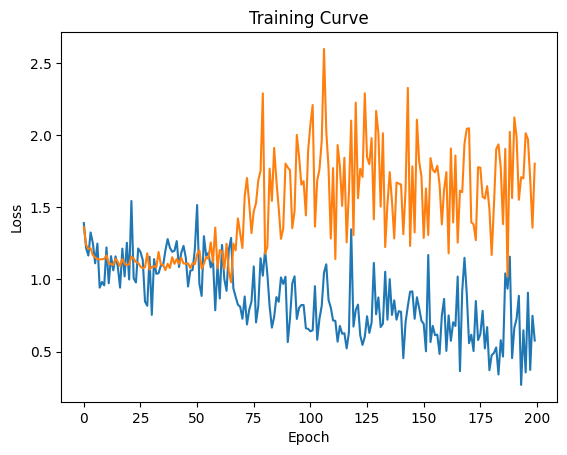

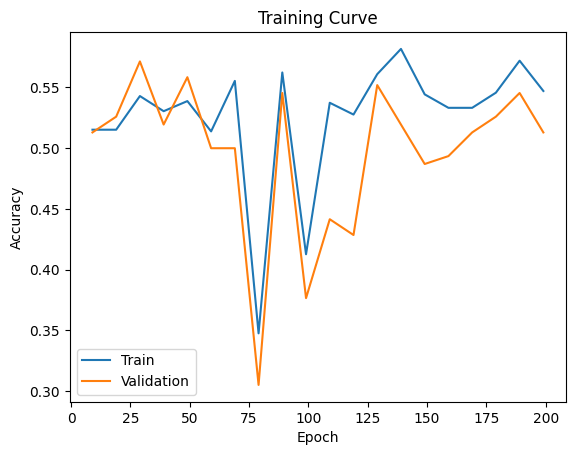

Best Valid Acc: 0.5714285714285714


In [73]:
#training LSTM + HR model
#this doens't work 
use_cuda = True
model= Classifier1D_feats(hidden_size1 = 256, hidden_size2 = 128)
if use_cuda and torch.cuda.is_available():
    model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.001,num_inputs=2);


Epoch 10; Train Loss 1.402232; Train Acc 0.153740; Val loss 1.379926; Val Acc 0.149351
Epoch 20; Train Loss 1.411981; Train Acc 0.153740; Val loss 1.380393; Val Acc 0.149351
Epoch 30; Train Loss 1.379650; Train Acc 0.153740; Val loss 1.380583; Val Acc 0.149351
Epoch 40; Train Loss 1.383994; Train Acc 0.153740; Val loss 1.380138; Val Acc 0.149351
Epoch 50; Train Loss 1.389583; Train Acc 0.157895; Val loss 1.378891; Val Acc 0.155844
Epoch 60; Train Loss 1.383709; Train Acc 0.159280; Val loss 1.377521; Val Acc 0.162338
Epoch 70; Train Loss 1.381758; Train Acc 0.159280; Val loss 1.375759; Val Acc 0.168831
Epoch 80; Train Loss 1.370377; Train Acc 0.160665; Val loss 1.372992; Val Acc 0.168831
Epoch 90; Train Loss 1.370522; Train Acc 0.160665; Val loss 1.369114; Val Acc 0.175325
Epoch 100; Train Loss 1.371407; Train Acc 0.162050; Val loss 1.364737; Val Acc 0.175325
Epoch 110; Train Loss 1.343620; Train Acc 0.167590; Val loss 1.359193; Val Acc 0.181818
Epoch 120; Train Loss 1.333007; Train Acc

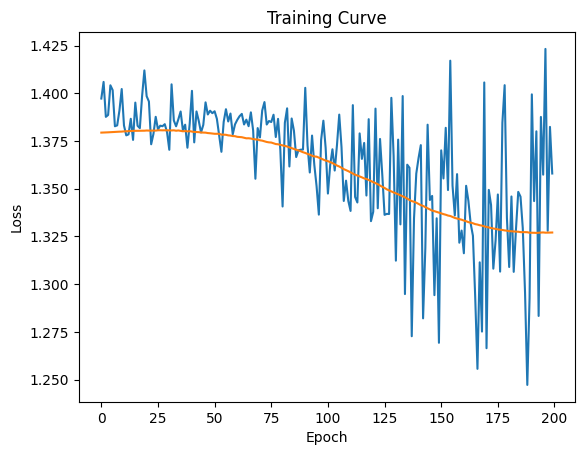

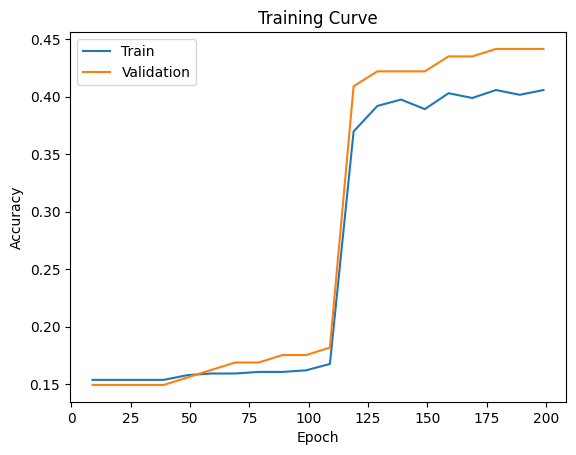

Best Valid Acc: 0.44155844155844154


In [85]:
#LSTM V2 -  this one doesn't work
use_cuda = True
model= Classifier1D(model = 1)
model = model.cuda()

train_network(model, train_loader1D, valid_loader1D, num_epochs=200, learning_rate=0.00001);


Epoch 10; Train Loss 1.170046; Train Acc 0.371191; Val loss 1.087116; Val Acc 0.370130
Epoch 20; Train Loss 1.042221; Train Acc 0.551247; Val loss 0.812754; Val Acc 0.532468
Epoch 30; Train Loss 0.892847; Train Acc 0.555402; Val loss 0.707343; Val Acc 0.577922
Epoch 40; Train Loss 0.451855; Train Acc 0.652355; Val loss 0.866179; Val Acc 0.577922
Epoch 50; Train Loss 0.562258; Train Acc 0.767313; Val loss 0.716353; Val Acc 0.623377
Epoch 60; Train Loss 0.274130; Train Acc 0.832410; Val loss 0.818447; Val Acc 0.629870
Epoch 70; Train Loss 0.125025; Train Acc 0.889197; Val loss 1.174188; Val Acc 0.623377
Epoch 80; Train Loss 0.147322; Train Acc 0.890582; Val loss 1.668034; Val Acc 0.584416
Epoch 90; Train Loss 0.019372; Train Acc 0.995845; Val loss 2.135086; Val Acc 0.642857
Epoch 100; Train Loss 0.003475; Train Acc 1.000000; Val loss 2.937391; Val Acc 0.681818


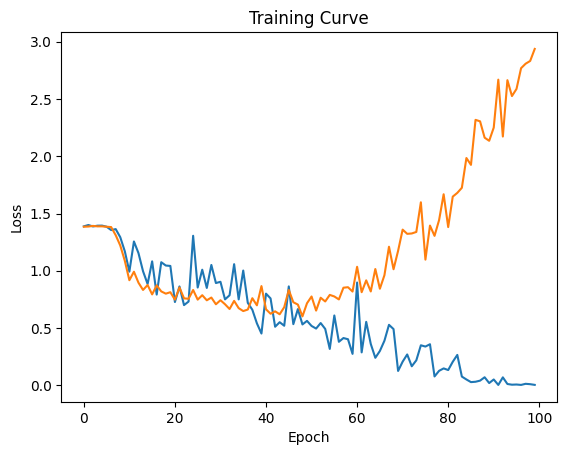

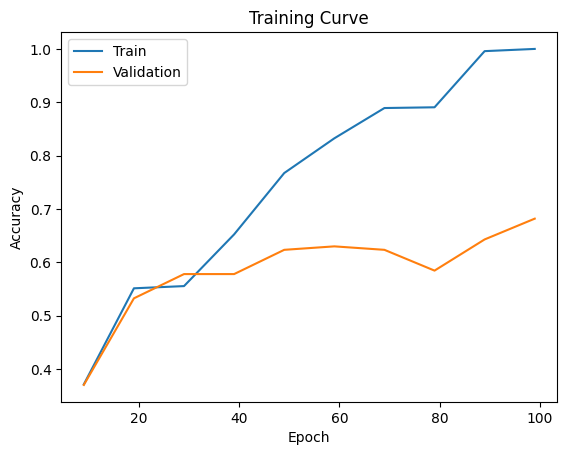

Best Valid Acc: 0.6818181818181818


In [108]:
#conv network
use_cuda = True
model= Classifier2D(model = 0)
model = model.cuda()

train_network(model, train_loader2D, valid_loader2D, num_epochs=100, learning_rate=0.001);


Epoch 10; Train Loss 1.384265; Train Acc 0.264543; Val loss 1.385219; Val Acc 0.298701
Epoch 20; Train Loss 1.394503; Train Acc 0.387812; Val loss 1.387886; Val Acc 0.376623
Epoch 30; Train Loss 1.388643; Train Acc 0.387812; Val loss 1.386989; Val Acc 0.376623
Epoch 40; Train Loss 1.384872; Train Acc 0.387812; Val loss 1.387096; Val Acc 0.376623
Epoch 50; Train Loss 1.389669; Train Acc 0.387812; Val loss 1.387977; Val Acc 0.376623
Epoch 60; Train Loss 1.385686; Train Acc 0.387812; Val loss 1.385741; Val Acc 0.376623
Epoch 70; Train Loss 1.384988; Train Acc 0.264543; Val loss 1.385992; Val Acc 0.298701
Epoch 80; Train Loss 1.385191; Train Acc 0.387812; Val loss 1.386386; Val Acc 0.376623
Epoch 90; Train Loss 1.383222; Train Acc 0.387812; Val loss 1.386959; Val Acc 0.376623
Epoch 100; Train Loss 1.389552; Train Acc 0.387812; Val loss 1.387613; Val Acc 0.376623
Epoch 110; Train Loss 1.386335; Train Acc 0.387812; Val loss 1.386766; Val Acc 0.376623
Epoch 120; Train Loss 1.385565; Train Acc

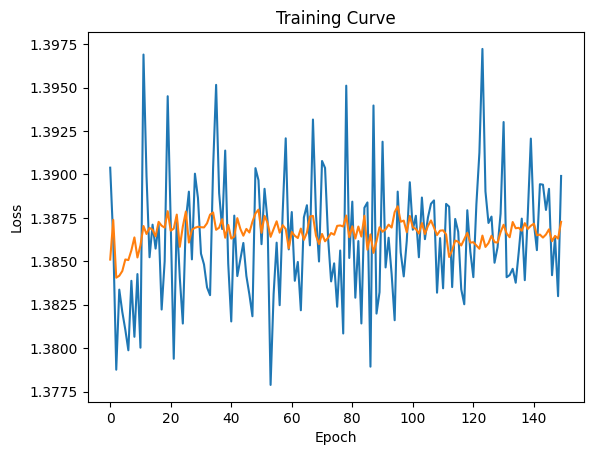

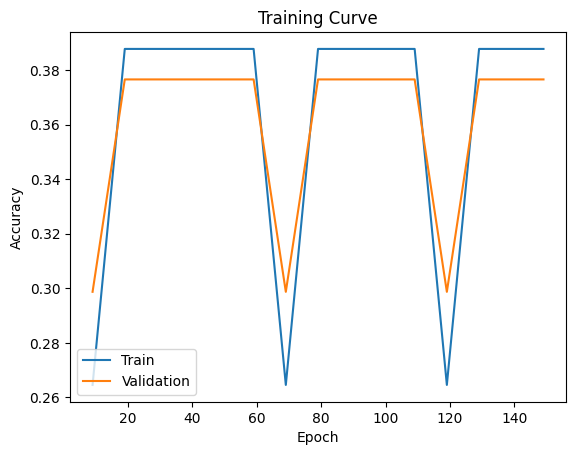

Best Valid Acc: 0.37662337662337664


In [109]:
#conv network
use_cuda = True
model= Classifier2D(model = 0, hidden_size1 = 128, hidden_size2 = 64)
model = model.cuda()

train_network(model, train_loader2D, valid_loader2D, num_epochs=150, learning_rate=0.001);


alexnet trained

Epoch 10; Train Loss 1.387480; Train Acc 0.264543; Val loss 1.387682; Val Acc 0.298701
Epoch 20; Train Loss 1.388103; Train Acc 0.387812; Val loss 1.384996; Val Acc 0.376623
Epoch 30; Train Loss 1.383708; Train Acc 0.387812; Val loss 1.386979; Val Acc 0.376623
Epoch 40; Train Loss 1.385123; Train Acc 0.264543; Val loss 1.386678; Val Acc 0.298701
Epoch 50; Train Loss 1.384173; Train Acc 0.387812; Val loss 1.387251; Val Acc 0.376623
Epoch 60; Train Loss 1.386323; Train Acc 0.264543; Val loss 1.385771; Val Acc 0.298701
Epoch 70; Train Loss 1.392884; Train Acc 0.195291; Val loss 1.388630; Val Acc 0.149351
Epoch 80; Train Loss 1.387276; Train Acc 0.387812; Val loss 1.386534; Val Acc 0.376623
Epoch 90; Train Loss 1.388126; Train Acc 0.387812; Val loss 1.387183; Val Acc 0.376623
Epoch 100; Train Loss 1.386886; Train Acc 0.264543; Val loss 1.385621; Val Acc 0.298701
Epoch 110; Train Loss 1.386573; Train Acc 0.387812; Val loss 1.388538; Val Acc 0.376623
Epoch 120; Train Loss 1.388102; Train Acc

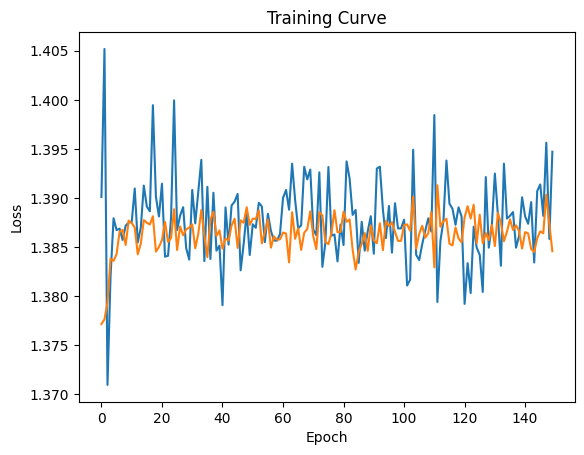

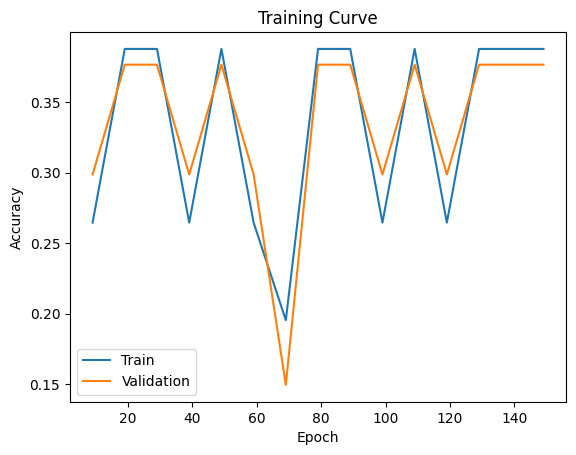

Best Valid Acc: 0.37662337662337664


In [107]:
#training alexnet
#okay never mind 
use_cuda = True
model= Classifier2D(model = 1)
model = model.cuda()

train_network(model, train_loader2D, valid_loader2D, num_epochs=150, learning_rate=0.01);


alexnet  pretrained features

Epoch 10; Train Loss 0.995326; Train Acc 0.657895; Val loss 0.913646; Val Acc 0.597403
Epoch 20; Train Loss 0.731528; Train Acc 0.720222; Val loss 0.820277; Val Acc 0.597403
Epoch 30; Train Loss 0.616569; Train Acc 0.759003; Val loss 0.859242; Val Acc 0.590909
Epoch 40; Train Loss 0.514257; Train Acc 0.825485; Val loss 0.798971; Val Acc 0.603896
Epoch 50; Train Loss 0.445404; Train Acc 0.840720; Val loss 0.781249; Val Acc 0.597403
Epoch 60; Train Loss 0.324800; Train Acc 0.844875; Val loss 0.878300; Val Acc 0.597403
Epoch 70; Train Loss 0.311740; Train Acc 0.901662; Val loss 0.811472; Val Acc 0.623377
Epoch 80; Train Loss 0.197851; Train Acc 0.921053; Val loss 0.832575; Val Acc 0.623377
Epoch 90; Train Loss 0.332709; Train Acc 0.948753; Val loss 0.937125; Val Acc 0.623377
Epoch 100; Train Loss 0.106202; Train Acc 0.973684; Val loss 0.821081; Val Acc 0.681818
Epoch 110; Train Loss 0.117701; Train Acc 0.979224; Val loss 0.857270; Val Acc 0.681818
Epoch 120; Train Loss 0.079917; Train Acc

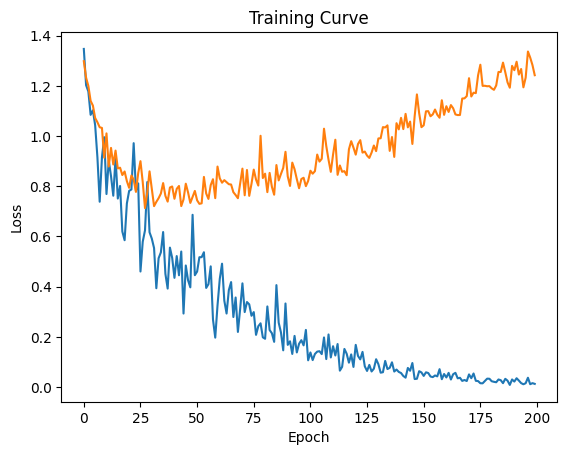

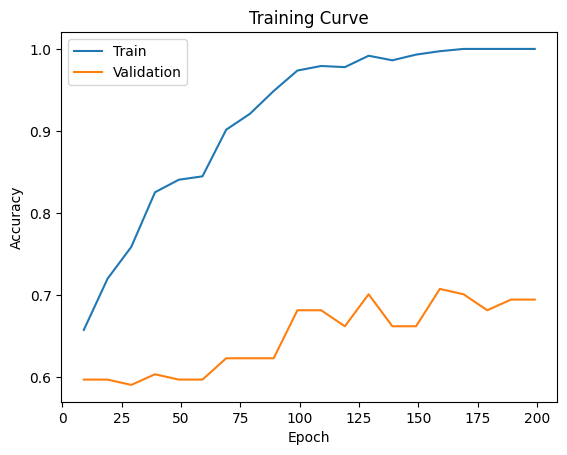

Best Valid Acc: 0.7077922077922078


In [91]:
model = ClassifierAN()
model.cuda()

train_network(model, train_loaderAN, valid_loaderAN, num_epochs=200, learning_rate=0.0001);

Epoch 10; Train Loss 0.990630; Train Acc 0.677285; Val loss 0.963256; Val Acc 0.636364
Epoch 20; Train Loss 0.651924; Train Acc 0.742382; Val loss 0.887415; Val Acc 0.642857
Epoch 30; Train Loss 0.676762; Train Acc 0.756233; Val loss 0.829740; Val Acc 0.636364
Epoch 40; Train Loss 0.475670; Train Acc 0.801939; Val loss 0.812273; Val Acc 0.616883
Epoch 50; Train Loss 0.394725; Train Acc 0.826870; Val loss 0.770576; Val Acc 0.610390
Epoch 60; Train Loss 0.509306; Train Acc 0.862881; Val loss 0.822658; Val Acc 0.629870
Epoch 70; Train Loss 0.282247; Train Acc 0.893352; Val loss 0.877393; Val Acc 0.649351
Epoch 80; Train Loss 0.307104; Train Acc 0.904432; Val loss 0.816575; Val Acc 0.649351
Epoch 90; Train Loss 0.295237; Train Acc 0.915512; Val loss 0.861253; Val Acc 0.629870
Epoch 100; Train Loss 0.348023; Train Acc 0.945983; Val loss 0.924721; Val Acc 0.662338
Epoch 110; Train Loss 0.223719; Train Acc 0.955679; Val loss 0.880453; Val Acc 0.681818
Epoch 120; Train Loss 0.158344; Train Acc

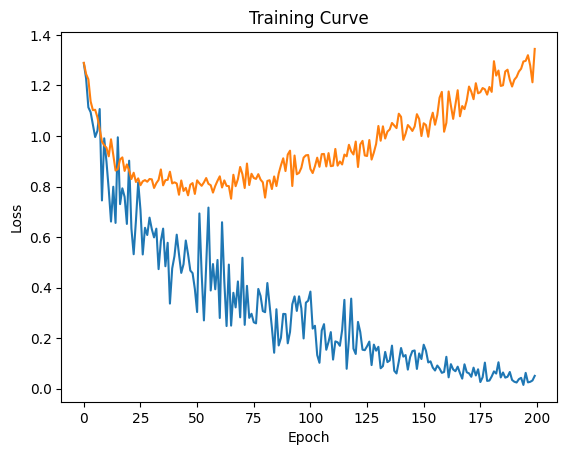

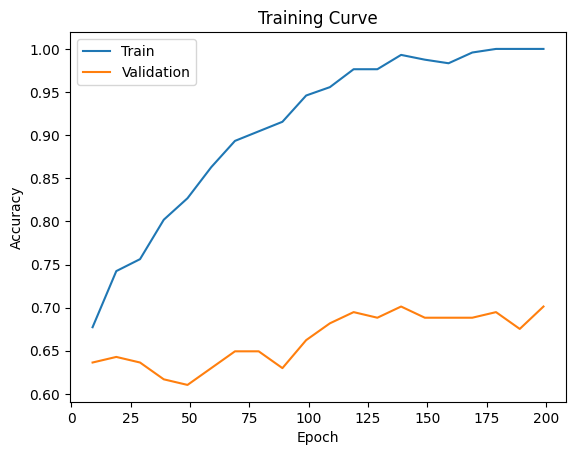

Best Valid Acc: 0.7012987012987013


In [81]:
model = ClassifierAN(l1 = 32, l2 = 16)
model.cuda()

train_network(model, train_loaderAN, valid_loaderAN, num_epochs=200, learning_rate=0.0001);

alexnet + HR

Epoch 10; Train Loss 1.238475; Train Acc 0.587258; Val loss 1.323460; Val Acc 0.435065
Epoch 20; Train Loss 1.171037; Train Acc 0.628809; Val loss 1.232899; Val Acc 0.493506
Epoch 30; Train Loss 1.103628; Train Acc 0.675900; Val loss 1.149394; Val Acc 0.538961
Epoch 40; Train Loss 1.017964; Train Acc 0.698061; Val loss 1.088288; Val Acc 0.571429
Epoch 50; Train Loss 1.076613; Train Acc 0.709141; Val loss 1.035398; Val Acc 0.584416
Epoch 60; Train Loss 0.872633; Train Acc 0.725762; Val loss 0.989392; Val Acc 0.597403
Epoch 70; Train Loss 0.645315; Train Acc 0.722992; Val loss 0.949058; Val Acc 0.610390
Epoch 80; Train Loss 0.987067; Train Acc 0.743767; Val loss 0.928722; Val Acc 0.616883
Epoch 90; Train Loss 0.896638; Train Acc 0.749307; Val loss 0.908310; Val Acc 0.610390
Epoch 100; Train Loss 0.568481; Train Acc 0.754848; Val loss 0.880607; Val Acc 0.623377
Epoch 110; Train Loss 0.671918; Train Acc 0.761773; Val loss 0.858821; Val Acc 0.623377
Epoch 120; Train Loss 0.745871; Train Acc

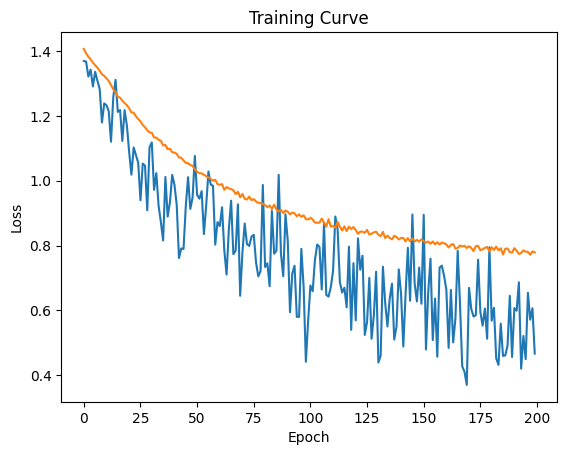

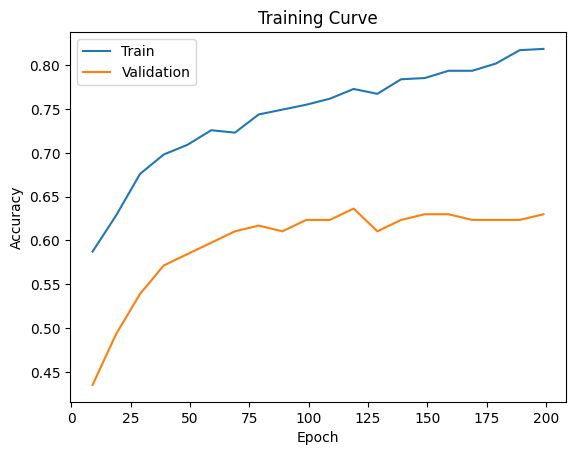

Best Valid Acc: 0.6363636363636364


In [78]:

model = ClassifierAN_feats()
model.cuda()

train_network(model, train_loaderAN, valid_loaderAN, num_epochs=200, learning_rate=0.00001,num_inputs = 2);

Epoch 10; Train Loss 1.309744; Train Acc 0.439058; Val loss 1.297095; Val Acc 0.493506
Epoch 20; Train Loss 1.218729; Train Acc 0.439058; Val loss 1.268927; Val Acc 0.448052
Epoch 30; Train Loss 1.191301; Train Acc 0.457064; Val loss 1.252275; Val Acc 0.344156
Epoch 40; Train Loss 1.188835; Train Acc 0.451524; Val loss 1.233032; Val Acc 0.337662
Epoch 50; Train Loss 1.121669; Train Acc 0.515235; Val loss 1.208219; Val Acc 0.370130
Epoch 60; Train Loss 1.025155; Train Acc 0.567867; Val loss 1.183905; Val Acc 0.435065
Epoch 70; Train Loss 1.005428; Train Acc 0.609418; Val loss 1.145676; Val Acc 0.506494
Epoch 80; Train Loss 1.010991; Train Acc 0.653740; Val loss 1.108493; Val Acc 0.545455
Epoch 90; Train Loss 0.934451; Train Acc 0.675900; Val loss 1.073705; Val Acc 0.577922
Epoch 100; Train Loss 1.171943; Train Acc 0.692521; Val loss 1.039173; Val Acc 0.603896
Epoch 110; Train Loss 0.947080; Train Acc 0.702216; Val loss 1.009074; Val Acc 0.623377
Epoch 120; Train Loss 0.849934; Train Acc

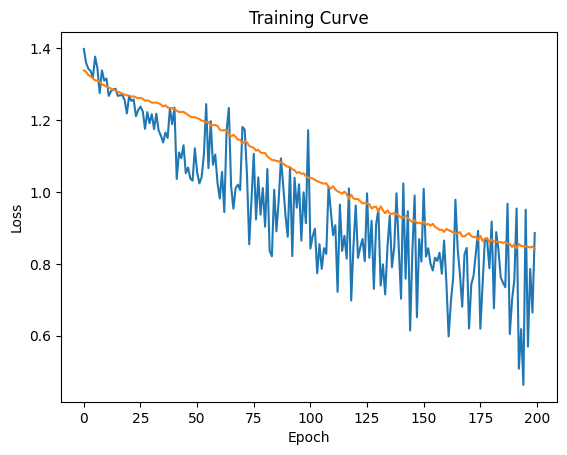

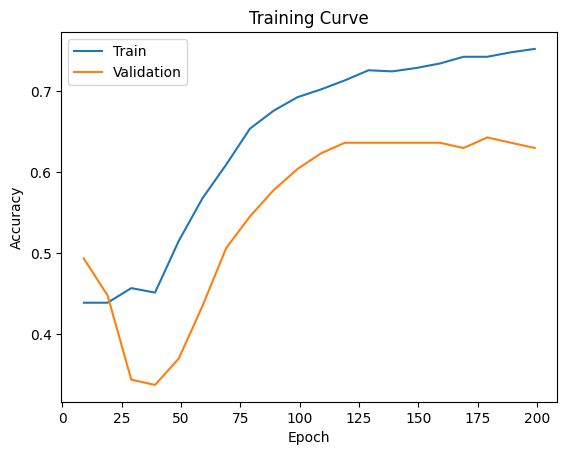

Best Valid Acc: 0.6428571428571429


In [84]:

model = ClassifierAN_feats(l1 = 32, l2 = 16)
model.cuda()

train_network(model, train_loaderAN, valid_loaderAN, num_epochs=200, learning_rate=0.00001,num_inputs = 2);

In [ ]:
#i think the issue is that i'm not training it on enough data 

TODO: hyperparameter tuning
* hidden size in FC part
* add dropout
* architecture of feature extraction part
    * LSTM settings
    * conv kernel size + filters
TODO: version where i do train alexnet features? 

TODO: confusion matrix

TODO: try classifying sleep/wake only

TODO: try adding extracted features (at the classifier step) - you'll need to completely rewrite your dataloader to take in the feature extraction code